In [1]:
import os
os.chdir("..")
#!pip install -r requirements.txt

### Библиотеки

In [2]:
import boto3
from dotenv import dotenv_values
import pandas as pd
from io import StringIO
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint

from portfolio_analytics.optimizer import Optimizer
from portfolio_analytics.utils import plot_efficient_frontier_curve

import warnings
warnings.filterwarnings('ignore')

config = dotenv_values(".env")

### Данные с S3

In [3]:
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['s3_aws_access_key_id'],
    aws_secret_access_key = config['s3_aws_secret_access_key']
)

In [4]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="prepared_data/test.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 

data = pd.read_csv(csv_data)
date_data = data.iloc[:,0]
stock_data = data.iloc[:,1:]

stock_data = stock_data.ffill().bfill()
stock_data

,YRSB,ROSN,MTSS,RTKM,TATN,WTCMP,OGKB,SNGS,UTAR,LPSB,...,SBERP,NLMK,MGTSP,RZSB,RTSB,APTK,VSMO,VRSBP,PLZL,ASSB
0,19.200,227.74,374.75,291.87,154.60,7.00,3.6400,30.501,17.950,5.352,...,69.62,104.60,793.1,1.849,0.378,1779.000,7610.00,4.50,1153.00,0.600
1,19.200,230.60,373.88,292.00,153.50,7.00,3.5270,30.430,18.230,5.400,...,70.00,105.00,793.0,1.726,0.379,1795.000,7681.00,4.40,1207.00,0.649
2,19.200,223.38,374.95,295.50,154.22,7.00,3.5440,30.400,18.644,5.550,...,70.30,105.00,770.0,1.722,0.378,1770.000,7635.00,4.45,1208.00,0.649
3,19.050,224.00,379.80,299.00,158.50,7.00,3.5600,30.692,18.290,5.450,...,70.41,104.00,773.0,1.720,0.380,1755.000,7600.00,4.10,1254.00,0.660
4,20.882,221.98,374.90,301.49,157.44,6.90,3.5500,30.400,18.459,5.420,...,71.00,104.00,780.0,1.670,0.377,1755.000,7635.06,4.20,1277.78,0.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,706.000,581.95,196.45,58.46,629.20,10.24,0.3228,23.655,13.030,63.300,...,270.32,135.30,800.0,28.420,2.370,10.806,22740.00,128.00,13973.50,1.480
4252,690.000,579.10,196.00,59.27,630.90,10.26,0.3252,24.000,13.260,63.700,...,269.25,133.78,810.0,28.340,2.360,10.742,22180.00,127.80,14001.00,1.540
4253,698.000,591.00,196.00,59.97,635.80,10.20,0.3273,23.870,13.240,62.100,...,272.01,134.86,810.0,28.360,2.320,10.674,22200.00,125.40,14139.00,1.555
4254,694.000,596.00,202.00,61.62,652.40,10.30,0.3280,24.115,13.010,62.450,...,273.50,139.62,828.0,28.400,2.300,10.650,22460.00,127.00,13926.00,1.560


In [5]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="stock_meta_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 
meta_data=pd.read_csv(csv_data).iloc[:,1:]
meta_data

,id,secid,shortname,regnumber,name,isin,is_traded,emitent_id,emitent_title,emitent_inn,emitent_okpo,gosreg,type,group,primary_boardid,marketprice_boardid
0,424433251,ABIO,iАРТГЕН ао,1-01-08902-A,"ПАО ""Артген""",RU000A0JNAB6,1,1142.0,"Публичное акционерное общество ""Артген биотех""",7.702509e+09,71328785.0,1-01-08902-A,common_share,stock_shares,TQBR,TQBR
1,12441,ABRD,АбрауДюрсо,1-02-12500-A,Абрау-Дюрсо ПАО ао,RU000A0JS5T7,1,4787.0,"Публичное акционерное общество ""Абрау – Дюрсо""",7.727621e+09,81521198.0,1-02-12500-A,common_share,stock_shares,TQBR,TQBR
2,2699,AFKS,Система ао,1-05-01669-A,"АФК ""Система"" ПАО ао",RU000A0DQZE3,1,777.0,"Публичное акционерное общество ""Акционерная фи...",7.703105e+09,27987276.0,1-05-01669-A,common_share,stock_shares,TQBR,TQBR
3,2700,AFLT,Аэрофлот,1-01-00010-A,Аэрофлот-росс.авиалин(ПАО)ао,RU0009062285,1,1242.0,"Публичное акционерное общество ""Аэрофлот – рос...",7.712040e+09,29063984.0,1-01-00010-A,common_share,stock_shares,TQBR,TQBR
4,76079,AGRO,AGRO-гдр,NaN,ГДР ROS AGRO PLC ORD SHS,US7496552057,1,7502.0,ROS AGRO PLC,1.003487e+07,NaN,NaN,depositary_receipt,stock_dr,TQBR,TQBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,8151,ziop,"АО ""ЗиО-Подольск""",1-01-04090-A,"Акционерное общество ""Машиностроительный завод...",RU000A0JQ6B5,0,3685.0,"Акционерное общество ""Машиностроительный завод...",5.036041e+09,NaN,1-01-04090-A,common_share,stock_shares,EQNE,NaN
2413,7778,ZIRE,ЗИРЕРА ао,1-01-57303-D,"""ЗИРЕРА"" ОАО - ао",RU000A0JRFT8,0,4518.0,"Открытое акционерное общество ""ЗИРЕРА""",1.655203e+09,68734469.0,1-01-57303-D,common_share,stock_shares,TQNE,NaN
2414,3898,ZMZN,ЗМЗ-ао,1-01-00230-A,Заволжский мотор.з-д ПАО ао,RU0009101539,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,1-01-00230-A,common_share,stock_shares,TQBR,TQBR
2415,3899,ZMZNP,ЗМЗ-ап,2-01-00230-A,Заволжский мотор.завод ПАО ап,RU0006752854,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,2-01-00230-A,preferred_share,stock_shares,TQBR,TQBR


### Доходности

In [6]:
stock_data

,YRSB,ROSN,MTSS,RTKM,TATN,WTCMP,OGKB,SNGS,UTAR,LPSB,...,SBERP,NLMK,MGTSP,RZSB,RTSB,APTK,VSMO,VRSBP,PLZL,ASSB
0,19.200,227.74,374.75,291.87,154.60,7.00,3.6400,30.501,17.950,5.352,...,69.62,104.60,793.1,1.849,0.378,1779.000,7610.00,4.50,1153.00,0.600
1,19.200,230.60,373.88,292.00,153.50,7.00,3.5270,30.430,18.230,5.400,...,70.00,105.00,793.0,1.726,0.379,1795.000,7681.00,4.40,1207.00,0.649
2,19.200,223.38,374.95,295.50,154.22,7.00,3.5440,30.400,18.644,5.550,...,70.30,105.00,770.0,1.722,0.378,1770.000,7635.00,4.45,1208.00,0.649
3,19.050,224.00,379.80,299.00,158.50,7.00,3.5600,30.692,18.290,5.450,...,70.41,104.00,773.0,1.720,0.380,1755.000,7600.00,4.10,1254.00,0.660
4,20.882,221.98,374.90,301.49,157.44,6.90,3.5500,30.400,18.459,5.420,...,71.00,104.00,780.0,1.670,0.377,1755.000,7635.06,4.20,1277.78,0.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,706.000,581.95,196.45,58.46,629.20,10.24,0.3228,23.655,13.030,63.300,...,270.32,135.30,800.0,28.420,2.370,10.806,22740.00,128.00,13973.50,1.480
4252,690.000,579.10,196.00,59.27,630.90,10.26,0.3252,24.000,13.260,63.700,...,269.25,133.78,810.0,28.340,2.360,10.742,22180.00,127.80,14001.00,1.540
4253,698.000,591.00,196.00,59.97,635.80,10.20,0.3273,23.870,13.240,62.100,...,272.01,134.86,810.0,28.360,2.320,10.674,22200.00,125.40,14139.00,1.555
4254,694.000,596.00,202.00,61.62,652.40,10.30,0.3280,24.115,13.010,62.450,...,273.50,139.62,828.0,28.400,2.300,10.650,22460.00,127.00,13926.00,1.560


In [7]:
ratio = (stock_data / stock_data.shift(1)).where(stock_data.shift(1) != 0, 1.0)
df_returns = np.log(ratio).iloc[1:,].reset_index(drop=True)
df_returns = df_returns.replace(-np.inf, 0)

### Анализ влияния ограничений в optimizer на границу эффективных портфелей

#### Задание 4

In [8]:
test_data_1_year = df_returns.iloc[:252,:]

#### Задание 5

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

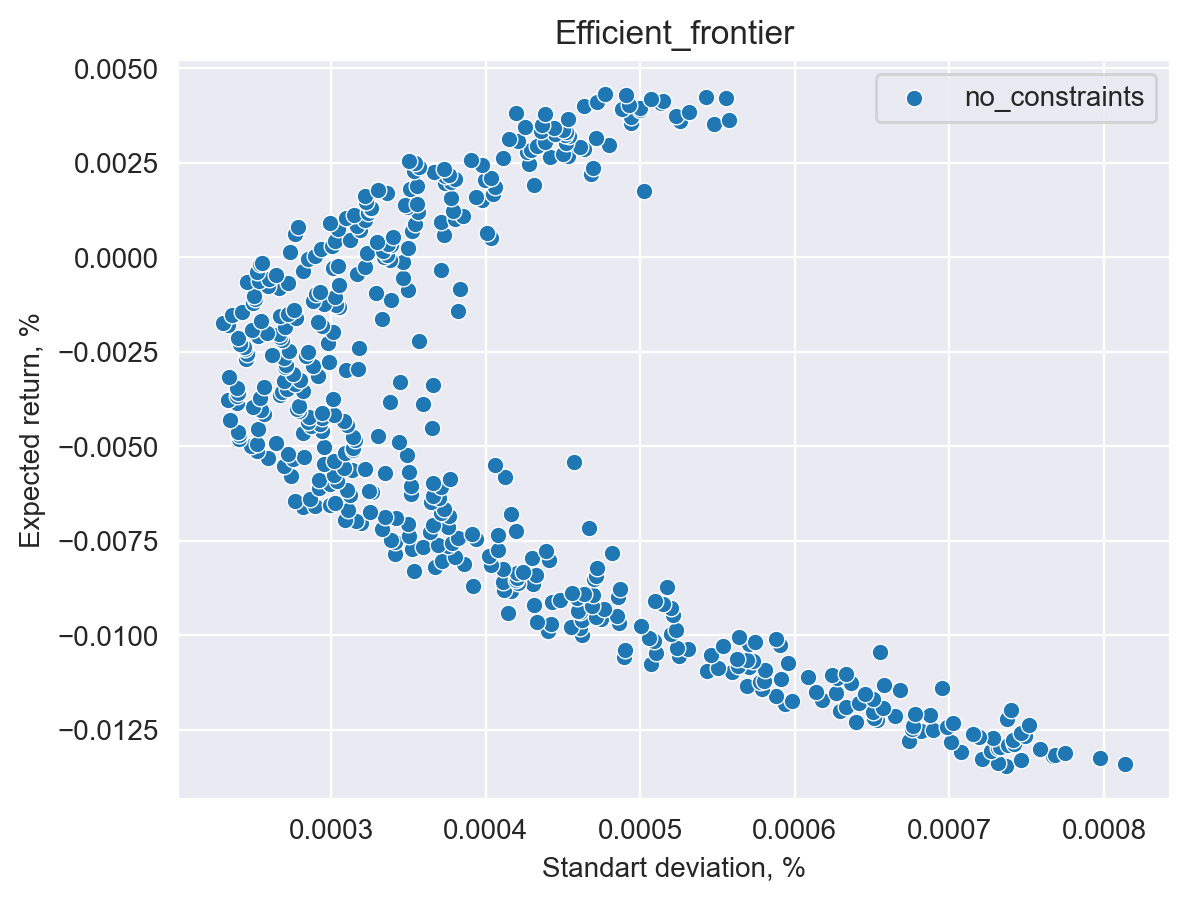

In [9]:
optim = Optimizer(test_data_1_year)
res_5 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)

#### Задание 6

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

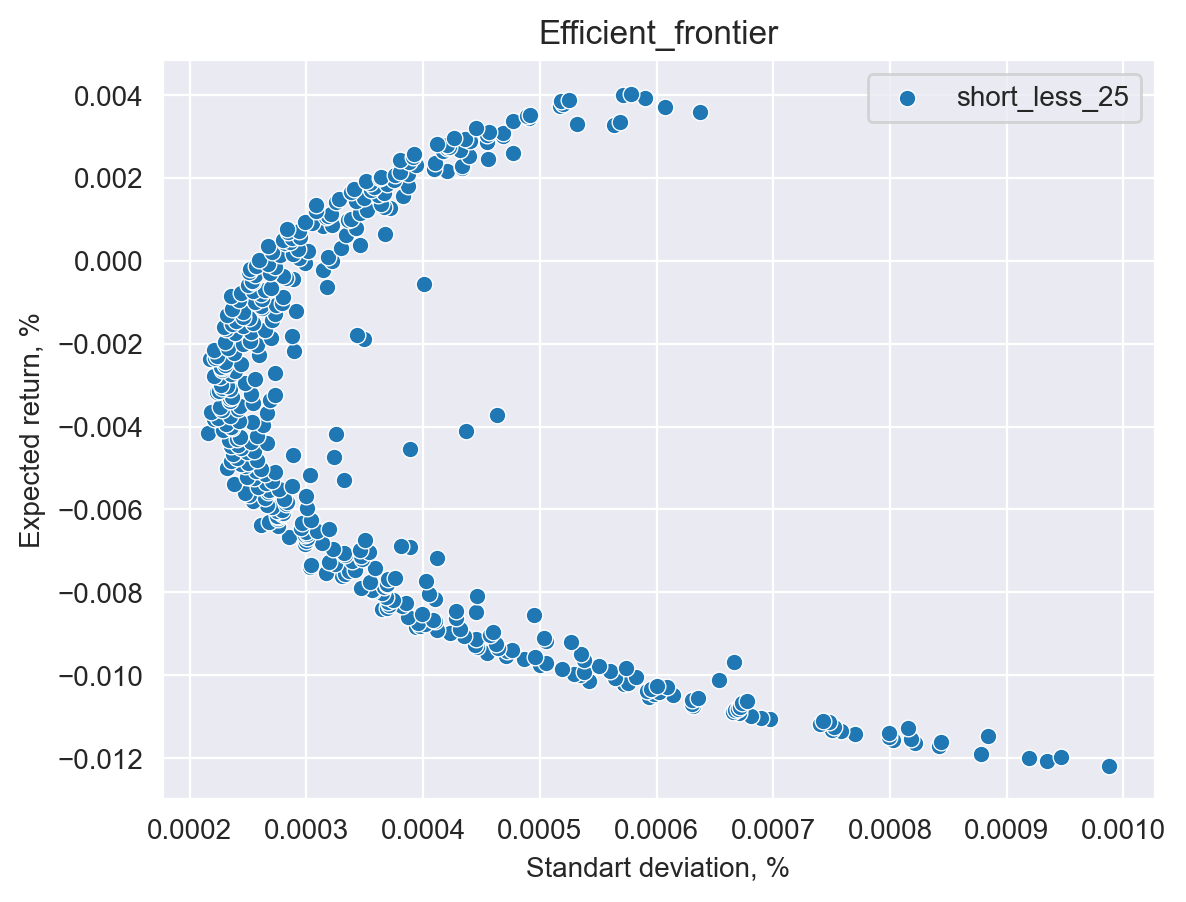

In [10]:
def sum_short(w):
    short_idx = np.where(w <= 0)
    total_short = np.sum(np.abs(w[short_idx]))
    return total_short

constr = [NonlinearConstraint(sum_short, 0.0, 0.25)]

optim = Optimizer(test_data_1_year, constrs=constr)
res_6 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_6], [x[0] for x in res_6], label='short_less_25', ax=ax)

#### Задание 7

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

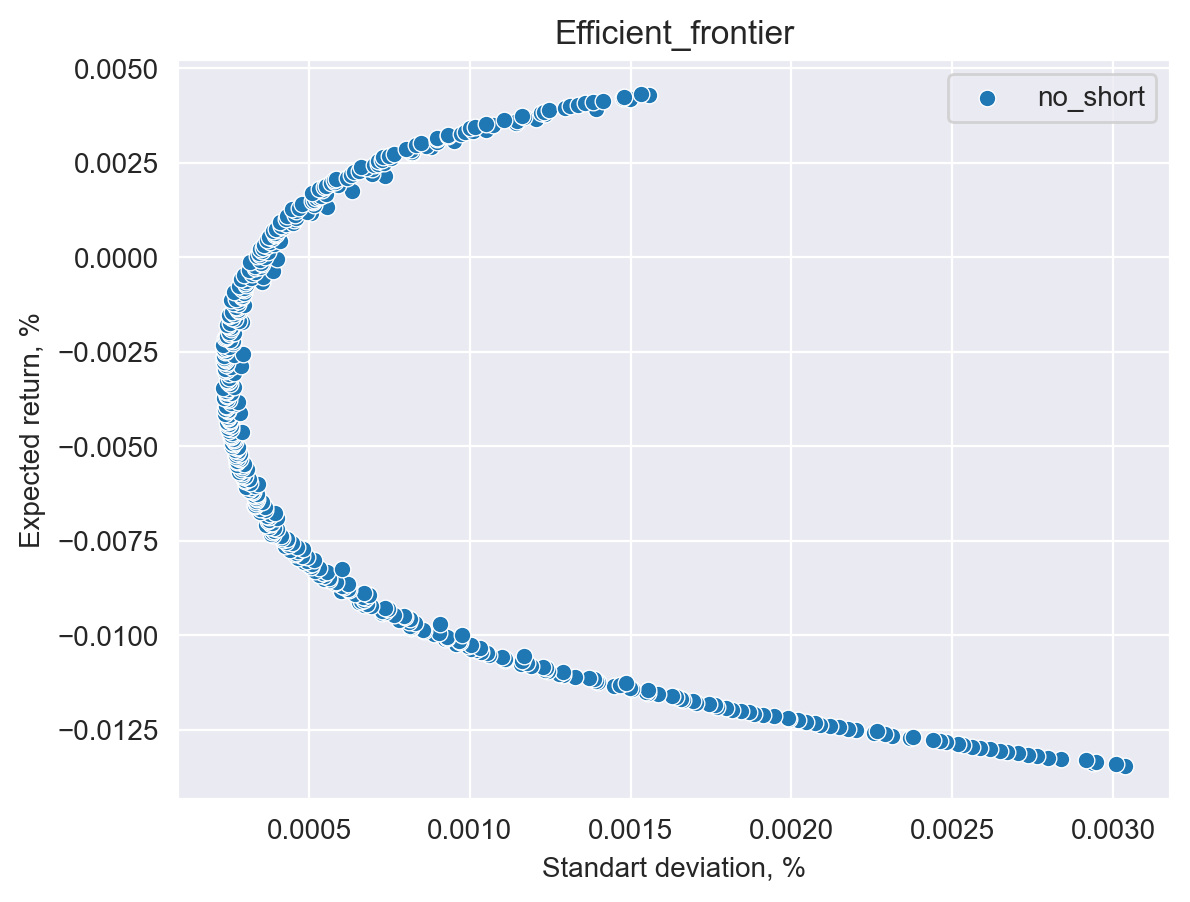

In [11]:
n_shares = test_data_1_year.shape[1]
no_short_bound = Bounds(np.zeros(n_shares), np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=no_short_bound)
res_7 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_7], [x[0] for x in res_7], label='no_short', ax=ax)

#### Задание 8

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

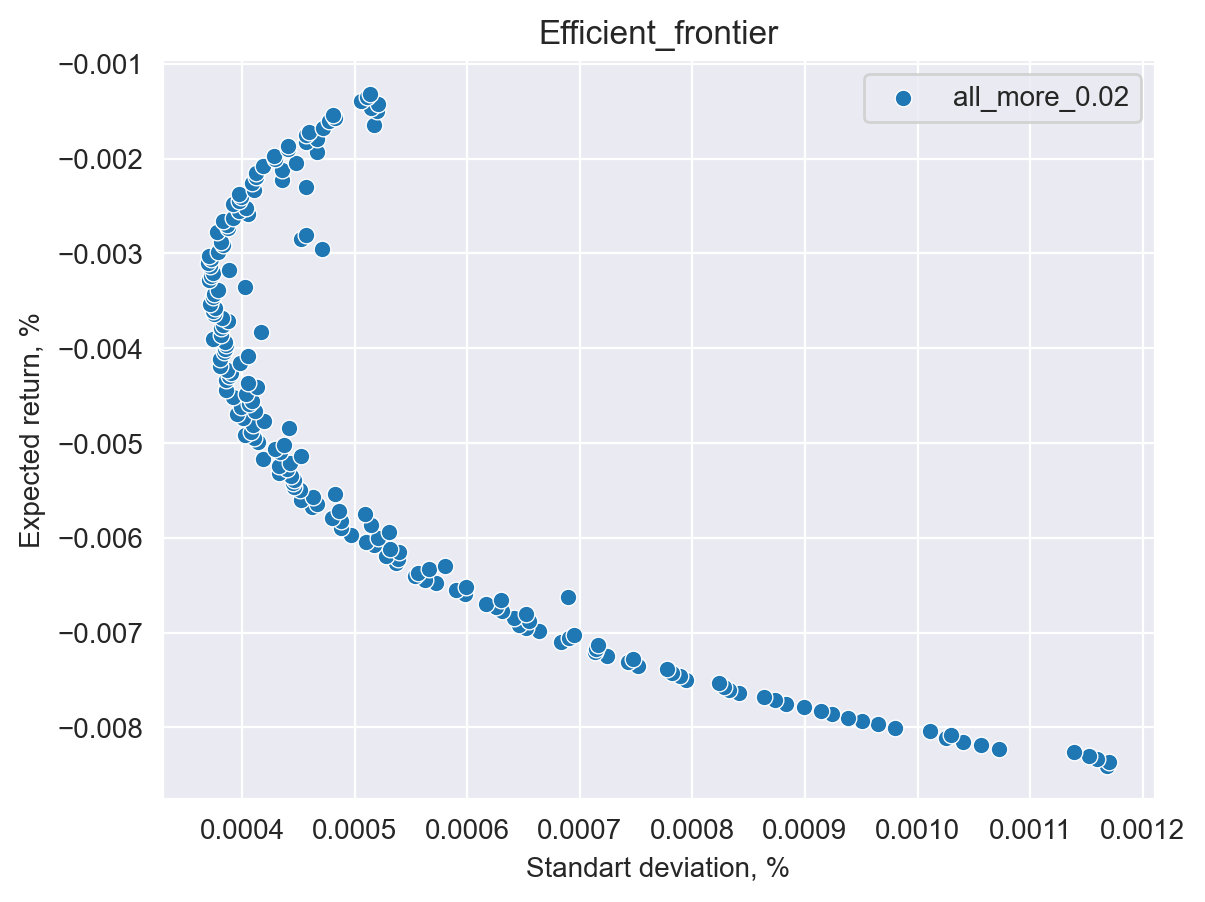

In [12]:
n_shares = test_data_1_year.shape[1]
min_bound = Bounds(np.zeros(n_shares)+0.02, np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=min_bound)
res_8 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_8], [x[0] for x in res_8], label='all_more_0.02', ax=ax)

<Figure size 800x800 with 0 Axes>

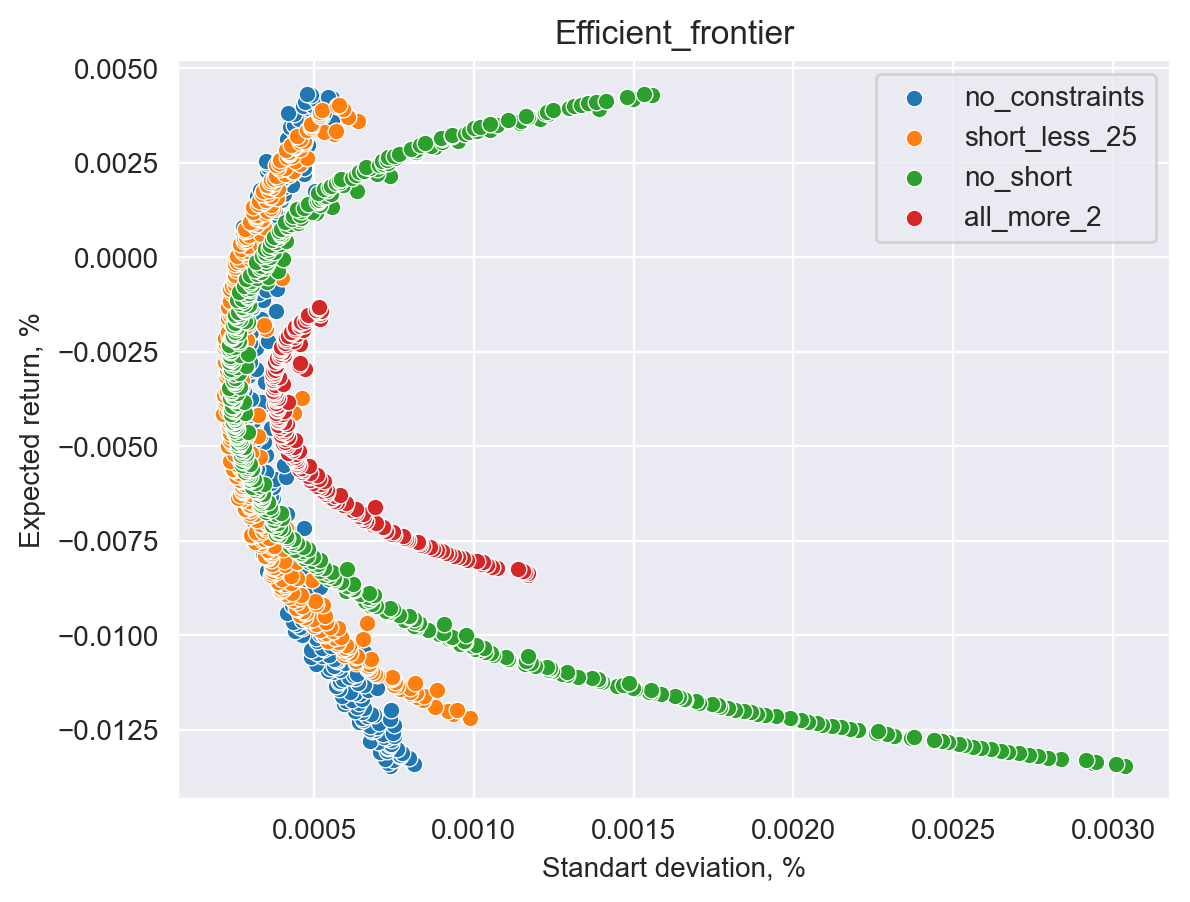

In [ ]:
#сравнение предыдущих пунктов
plt.figure(figsize=(8,8))
fig, ax = plt.subplots()

plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_6], [x[0] for x in res_6], label='short_less_25', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_7], [x[0] for x in res_7], label='no_short', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_8], [x[0] for x in res_8], label='all_more_2', ax=ax)

#### Задание 9

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

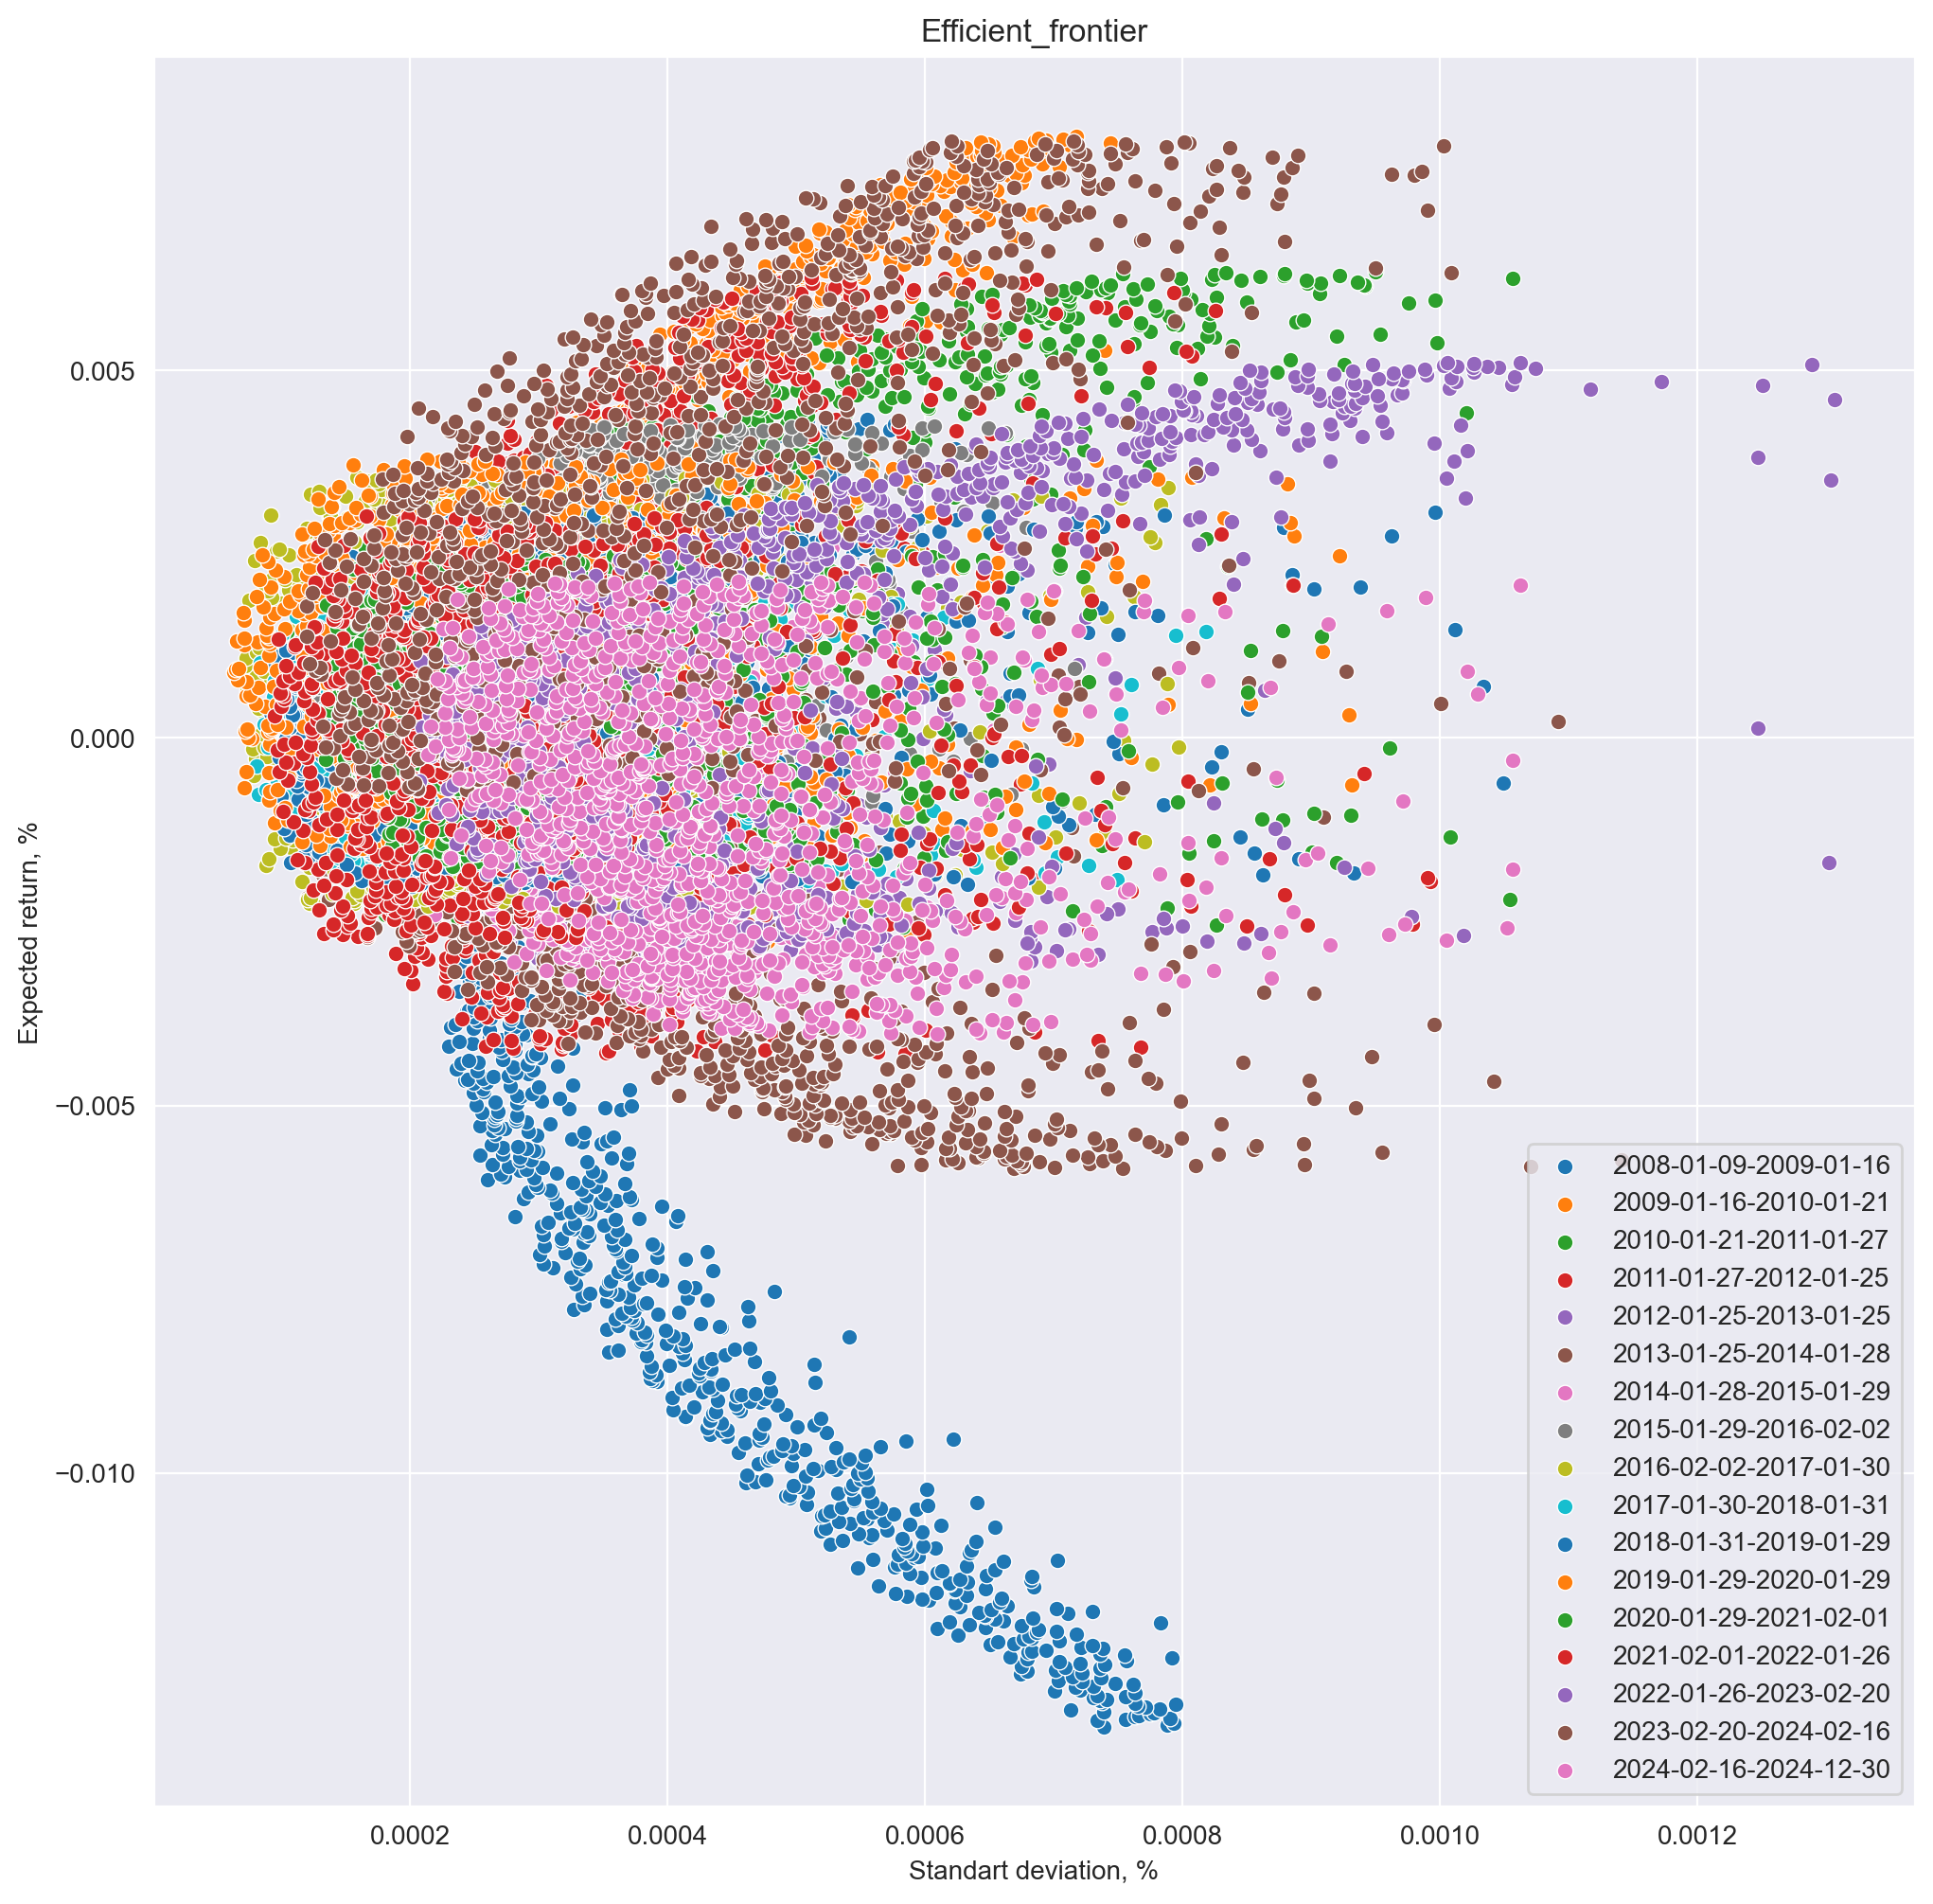

In [9]:
steps = 252
window = 252

fig, ax = plt.subplots(figsize=(12,12))
for step in tqdm(range(0, len(df_returns), steps)):
    df_returns_sclice = df_returns.iloc[step:window+step]

    optim = Optimizer(df_returns_sclice)
    res_slice = optim.efficient_frontier_curve(n_point=1000)

    if len(res_slice) == 0:
        continue

    plot_efficient_frontier_curve([x[1] for x in res_slice], [x[0] for x in res_slice], label=f'{date_data[step]}-{date_data[min(window+step, len(date_data)-1)]}', ax=ax)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

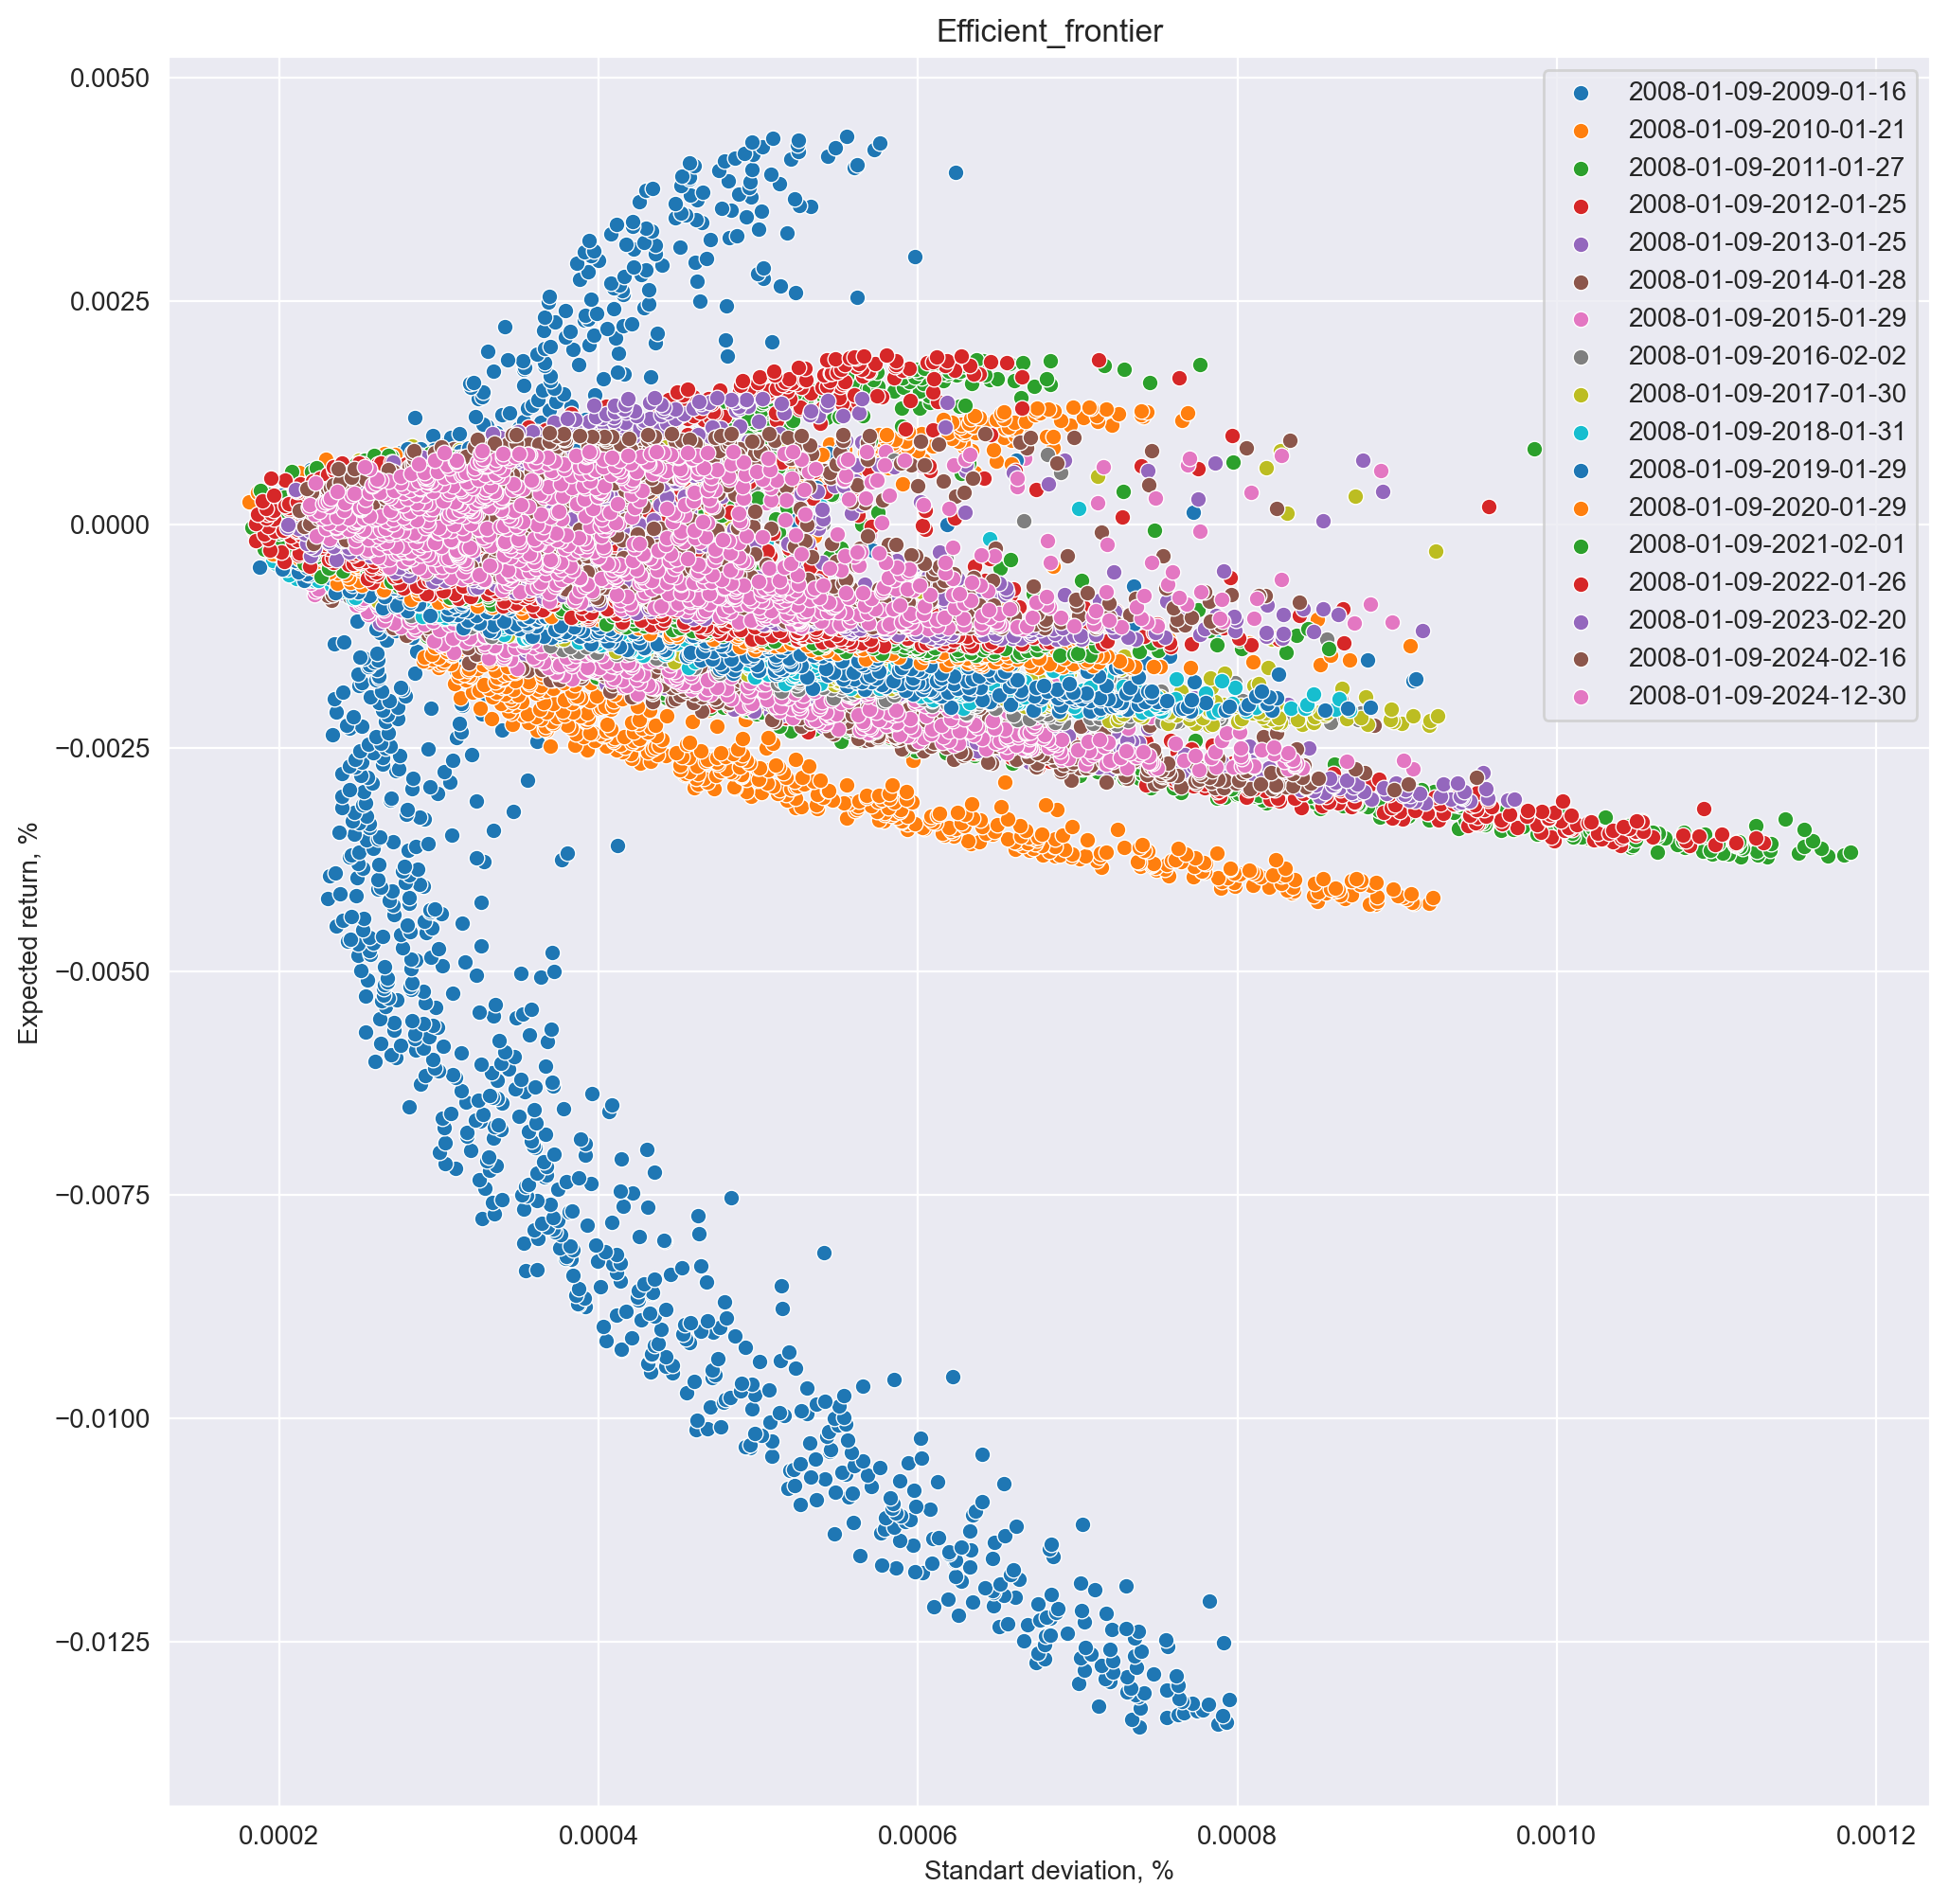

In [10]:
steps = 252
window = 252

fig, ax = plt.subplots(figsize=(12,12))
for step in tqdm(range(0, len(df_returns), steps)):
    df_returns_sclice = df_returns.iloc[0:window+step]

    optim = Optimizer(df_returns_sclice)
    res_slice = optim.efficient_frontier_curve(n_point=1000)

    if len(res_slice) == 0:
        continue

    plot_efficient_frontier_curve([x[1] for x in res_slice], [x[0] for x in res_slice], label=f'{date_data[0]}-{date_data[min(window+step, len(date_data)-1)]}', ax=ax)

#### Задание 10

### Задание 11

In [ ]:
# date_df = pd.DataFrame(stock_data['begin'])
# index_data = pd.read_csv("IMOEX.csv", delimiter=';') # https://www.investing.com/indices/mcx-historical-data
# imoex_date = pd.merge(date_df, index_data, how='left', on='begin')
# imoex_date['IMOEX'] = imoex_date['IMOEX'].str.replace(',', '.').astype(float)
# csv_data = imoex_date.to_csv(index=False).encode('utf-8')
# s3.put_object(
#     Bucket='portfoliodata',
#     Key=f'IMOEX.csv',
#     Body=csv_data
# )

### Задание 22

In [258]:
data = res_5.copy()

total_portfolio = len(data)
cov_matrix = test_data_1_year.cov()
mean_target = test_data_1_year.mean()

In [272]:
np.random.seed(42)

results_df = pd.DataFrame({
    "p1":[], 
    "p2":[], 
    "p_target":[], 
    "alpha":[], 
    "beta":[], 
    "r_taget":[], 
    "std_targer":[],
    "r_rep":[], 
    "std_rep":[],
    "success":[]
})

n_exp = 10000
for i in tqdm(range(n_exp)):

    # семплируем рандомные 3 порфеля
    idx1, idx2, idx3 = np.random.choice([x for x in range (total_portfolio)], 3, replace=False)

    # берем веса первых двух
    w_1 = data[idx1][2]
    w_2 = data[idx2][2]

    # восстанавливаем третий
    r_target = data[idx3][0]
    std_target = data[idx3][1]

    def portfolio_var(coef):
        "Отклонение текущего портфеоя от таргетного"
        w = w_1 * coef[0] + w_2 * coef[1]
        w_matrix = w.reshape(-1, 1) @ w.reshape(1, -1)
        total_var = (w_matrix * cov_matrix).sum().sum()
        return np.abs(total_var - std_target) * 10000

    def expect_return(coef):
        "Проверка на равенстве ожидаемой доходности"
        w = w_1 * coef[0] + w_2 * coef[1]
        r = (mean_target * w).sum()
        return r


    expect_return_constr = NonlinearConstraint(expect_return, r_target, r_target)
    constr = [expect_return_constr]

    best_res = None
    best_score = 1e6
    for _ in range(5):
        init_coef = np.random.uniform(-1, 1, 2)
        res = minimize(
            portfolio_var, 
            x0=init_coef, 
            method='SLSQP', 
            tol=1e-10, 
            constraints=constr,
            options={
                "maxiter":10000
            })
        if res.fun <= best_score:
            best_score = res.fun
            best_res = res
    
    # валидация и логирование результатов
    w_rep = best_res.x[0] * w_1 + best_res.x[1] * w_2
    r_rep = expect_return(best_res.x)
    std_rep = Optimizer.portfolio_var(w_rep, cov_matrix)
    success = 1 * best_res.success if abs((std_target - std_rep) / std_target) <= 0.1 else 0
    results_df.loc[len(results_df)] = [idx1, idx2, idx3, best_res.x[0], best_res.x[1], r_target, std_target, r_rep, std_rep, success]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [273]:
results_df

,p1,p2,p_target,alpha,beta,r_taget,std_targer,r_rep,std_rep,success
0,456.0,73.0,310.0,0.836762,0.441527,-0.002226,0.000357,-0.002226,0.000357,1.0
1,455.0,453.0,149.0,-2.278224,-0.375450,-0.008152,0.000404,-0.008152,0.002932,0.0
2,70.0,313.0,120.0,0.835905,-0.018528,-0.009206,0.000431,-0.009206,0.000431,1.0
3,400.0,188.0,137.0,-0.759613,1.163606,-0.008588,0.000411,-0.008588,0.000411,1.0
4,112.0,482.0,93.0,0.770973,-0.714156,-0.010224,0.000571,-0.010224,0.000571,1.0
...,...,...,...,...,...,...,...,...,...,...
9995,31.0,262.0,58.0,0.795788,0.383718,-0.011497,0.000614,-0.011497,0.000614,1.0
9996,176.0,121.0,429.0,-1.816528,1.184135,0.002101,0.000403,0.002101,0.000403,1.0
9997,277.0,111.0,349.0,-1.293135,0.554328,-0.000808,0.000266,-0.000808,0.000266,1.0
9998,105.0,376.0,411.0,-0.130629,0.992141,0.001446,0.000323,0.001446,0.000323,1.0


In [274]:
results_df['success'].mean()

0.7756